# Imports and Data Loading

In [1]:
import pandas as pd
import requests
import os

In [2]:
DATADIR = r"D:\data\claim_identification_corpus"

In [3]:
essays = pd.read_excel(os.path.join(DATADIR, "essay_scores.xlsx"))

# Extract Essays

In [15]:
def get_essay(filename):
    df = pd.read_csv(os.path.join(DATADIR, "Data", filename + ".csv"))

    res = []

    ind_para = 1
    while ind_para < len(df):
        this_para = df['discourse_part'] == "Paragraph_" + str(ind_para)
        if not any(this_para):
            break
        text = ' '.join(df['discourse_text'][this_para])
        res.append(text)
        ind_para += 1
    
    return '\n'.join(res)

In [16]:
essays['Text'] = essays['Essay'].apply(get_essay)

In [17]:
max(essays['Text'].apply(len))

4273

# Extract Essays by Annotation

In [17]:
all_essays = []

for i, row in essays.iterrows():
    try:
        filepath = f"{DATADIR}/Data/{row['Essay']}.csv"
        df = pd.read_csv(filepath)
    except FileNotFoundError as e:
        print(e)
        continue
    
    df['essay'] = row['Essay']
    df['score'] = row['Holistic Score']

    all_essays.append(df)

In [19]:
annot = pd.concat(all_essays, ignore_index=True)
annot

,discourse_id,discourse_part,discourse_boundary,discourse_text,adjudicated_discourse_type,adjudicated_effectiveness,adjudicated_hierarchical,adjudicated_parallel,essay,score
0,"1_MSU_essay|Paragraph_1|Nonannotated|0,20",Paragraph_1,"(0, 20)",Heroes or Celebrities,Nonannotated,-,-,-,1_MSU_essay,5.0
1,"1_MSU_essay|Paragraph_2|Nonannotated|0,565",Paragraph_2,"(0, 565)",Celebrities and heroes are often confused in t...,Nonannotated,-,-,-,1_MSU_essay,5.0
2,"1_MSU_essay|Paragraph_2|Final_Claim|567,660",Paragraph_2,"(567, 660)",This idea of a hero has been forgotten and sho...,Final_Claim,adequate,-,-,1_MSU_essay,5.0
3,"1_MSU_essay|Paragraph_3|Data|0,519",Paragraph_3,"(0, 519)",How does one define a hero? Is it because of t...,Data,effective,"Paragraph_3|Primary_Claim|521,628",-,1_MSU_essay,5.0
4,"1_MSU_essay|Paragraph_3|Primary_Claim|521,628",Paragraph_3,"(521, 628)","Although many people do heroic things, they ar...",Primary_Claim,effective,"Paragraph_2|Final_Claim|567,660","Paragraph_4|Primary_Claim|449,553",1_MSU_essay,5.0
...,...,...,...,...,...,...,...,...,...,...
2259,"9b_MSU_essay|Paragraph_2|Data|130,443",Paragraph_2,"(130, 443)",The first time a person learns that a certain ...,Data,adequate,"Paragraph_2|Primary_Claim|0,128",-,9b_MSU_essay,3.5
2260,"9b_MSU_essay|Paragraph_3|Primary_Claim|0,170",Paragraph_3,"(0, 170)",It is hard for people to develop new original ...,Primary_Claim,adequate,"Paragraph_1|Final_Claim|142,726","Paragraph_2|Primary_Claim|0,128; Paragraph_4|P...",9b_MSU_essay,3.5
2261,"9b_MSU_essay|Paragraph_3|Data|172,489",Paragraph_3,"(172, 489)","For example, producers of TV shows strive to p...",Data,adequate,"Paragraph_3|Primary_Claim|0,170",-,9b_MSU_essay,3.5
2262,"9b_MSU_essay|Paragraph_4|Primary_Claim|0,174",Paragraph_4,"(0, 174)",Almost every product one can think of has alre...,Primary_Claim,adequate,"Paragraph_1|Final_Claim|142,726","Paragraph_2|Primary_Claim|0,128; Paragraph_3|P...",9b_MSU_essay,3.5


In [13]:
gpt_sifr = GPT2PPL()

In [22]:
gpt_sifr.getPPL(annot['discourse_text'][0])

421

In [23]:
annot['ppl'] = annot['discourse_text'].apply(gpt_sifr.getPPL)

In [25]:
annot.to_csv(f"{DATADIR}/AnnotsWithPPL.csv")

## For uploading to GPTZero

In [20]:
def export_essays(essays, folder = "Exports", extension = "txt"):
    assert 'Text' in essays.columns

    def export(row):
        filename = os.path.join(DATADIR, folder, f"{row['Essay']}.{extension}")
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(row['Text'])
    
    essays.apply(export, axis=1)

In [21]:
export_essays(essays)

# GPTZero

The class GPTZeroAPI comes courtesy of https://github.com/Haste171/gptzero.

See https://gptzero.me/docs for more details.

In [ ]:
class GPTZeroAPI:

    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = 'https://api.gptzero.me/v2/predict'
    
    def text_predict(self, document):
        url = f'{self.base_url}/text'
        headers = {
            'accept': 'application/json',
            'X-Api-Key': self.api_key,
            'Content-Type': 'application/json'
        }
        data = {
            'document': document
        }
        response = requests.post(url, headers=headers, json=data)
        return response.json()

# Tayyab and Chua's Implementation

GPTZero costs money to use the API :(

Let's try this version instead, where Tayyab and Chua attempt to imitate
GPTZero's methods. They claim that they achieve the same results.

https://github.com/BurhanUlTayyab/GPTZero

In [11]:
import torch
import re
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from collections import OrderedDict

d:\SadPrograms\anaconda\envs\openai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class GPT2PPL:

    def __init__(self, device = "cpu", model_id = "gpt2"):
        self.device = device
        self.model_id = model_id
        self.model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

        self.max_length = self.model.config.n_positions
        self.stride = 512

    def __call__(self, sentence):
        """Take a sentence split by full stop and print perplexity.
        
        Burstiness is the max perplexity of each sentence.
        """
        results = OrderedDict()

        total_valid_char = re.findall("[a-zA-Z0-9]+", sentence)
        total_valid_char = sum([len(x) for x in total_valid_char])

        # print(total_valid_char)
        # assert total_valid_char >= 100
        if total_valid_char < 100:
            return

        lines = re.split(r'(?<=[.?!][ \[\(])|(?<=\n)\s*', sentence)
        lines = list(filter(lambda x: (x is not None) and (len(x) > 0), lines))

        ppl = self.getPPL(sentence)
        results['perplexity'] = ppl

        offset = ""
        ppl_per_line = []
        for line in lines:
            if re.search("[a-zA-Z0-9]+", line) == None:
                continue
            if len(offset) > 0:
                line = offset + line
                offset = ""
            
            # remove the new line or space in the first sentence if it exists
            if line[0] == '\n' or line[0] == ' ':
                line = line[1:]
            if line[-1] == '\n' or line[-1] == ' ':
                line = line[:-1]
            elif line[-1] == '[' or line[-1] == '(':
                offset = line[-1]
                line = line[:-1]
            
            ppl = self.getPPL(line)
            ppl_per_line.append(ppl)
    
        results['ppl_per_line'] = sum(ppl_per_line) / len(ppl_per_line)
        results['burstiness'] = max(ppl_per_line)

        return results

    def getPPL(self, sentence):
        encodings = self.tokenizer(sentence, return_tensors = "pt")
        seq_len = encodings.input_ids.size(1)

        nlls = []
        likelihoods = []
        prev_end_loc = 0
        for begin_loc in range(0, seq_len, self.stride):
            end_loc = min(begin_loc + self.max_length, seq_len)
            trg_len = end_loc - prev_end_loc
            input_ids = encodings.input_ids[:, begin_loc:end_loc]
            input_ids = input_ids.to(self.device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = self.model(input_ids, labels = target_ids)
                neg_log_likelihood = outputs.loss * trg_len
                likelihoods.append(neg_log_likelihood)
            
            nlls.append(neg_log_likelihood)

            prev_end_loc = end_loc
            if end_loc == seq_len:
                break
        
        ppl = int(torch.exp(torch.stack(nlls).sum() / end_loc))
        return ppl

In [33]:
gpt_sifr = GPT2PPL()

In [34]:
gpt_sifr(essays['Text'][0])

1965


OrderedDict([('perplexity', 21),
             ('ppl_per_line', 64.375),
             ('burstiness', 421)])

In [35]:
def averagePPL(text):
    data = gpt_sifr(text)
    return data['ppl_per_line']

In [ ]:
essays['LinePPL'] = essays['Text'].apply(averagePPL)

In [37]:
essays

,Essay,Number of words,Holistic Score,Text,LinePPL
0,1_MSU_essay,426,5.0,Heroes or Celebrities\nCelebrities and heroes ...,64.375000
1,10_MSU_essay,262,3.5,"Musicians, artists, writers, scientists, and m...",46.083333
2,100_MSU_essay,191,2.5,People have the freedom to choose what they wa...,73.214286
3,100b_MSU_essay,233,3.5,"Anyone can become a celebrity, but to become a...",69.727273
4,101_MSU_essay,365,1.5,Most people at a young age have those certain ...,94.900000
...,...,...,...,...,...
309,98_MSU_essay,542,4.5,"In our modern day society, it has become commo...",46.407407
310,98b_MSU_essay,480,4.0,"In an age of celebrity worship, where movie st...",71.562500
311,99_MSU_essay,357,2.5,"A limo pulls up, cameras are constantly flashi...",60.941176
312,99b_MSU_essay,378,2.0,Heroes and celebrities are clearly different. ...,57.136364


In [38]:
essays.to_csv(os.path.join(DATADIR, "EssaysWithPPL.csv"))

# Testing for Difference between GPTZero and TayyabChua

(Written 6pm, 4/2/2023)

The TayyabChua algorithm is identifying as many essays as being as human-written as they are AI-generated. This is a mistake, as all of the essays were human-written. Is this an issue of GPTZero having a lot of false positives, or is it an issue of TayyabChua's implementation being imperfect?

To test this, I am grabbing a random sample of 30 human-written essays from the Claim Identifican Corpus and finding their scores for both GPTZero and TayyabChua.

In [2]:
import rpy2

%load_ext rpy2.ipython

d:\SadPrograms\anaconda\envs\openai\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
library(tidyverse)  # for data manipulation and cleanup
library(magrittr)   # for %>%
library(stats)      # for qqnorm, qqplot
library(janitor)

setwd("D:/data/claim_identification_corpus")

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.8     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


R[write to console]: 
Attaching package: 'magrittr'


R[write to console]: The following object is masked from 'package:purrr':

    set_names


R[write to console]: The following object is masked from 'package:tidyr':

    extract


R[write to console]: 
Attaching package: 'janitor'


R[write to console]: The following objects are masked from 'package:stats':

    chisq.test, fisher.test




## Test 1

We expect the result for the TayyabChua to be exactly the same as the result for GPTZero for every essay.

$H_0: p_\text{same} = 0$

$H_\alpha: p_\text{same} > 0$

$p_\text{same}$ is the proportion of all essays in the Claim Identification Corpus that have the exact same perplexity score between GPTZero and TayyabChua (rounded to the nearest whole number).

### Random Sample

In [4]:
%%R
set.seed(0)

df <- read.csv("EssaysWithPPL.csv") %>%
    rename(filename = Essay,
           nwords = Number.of.words,
           score = Holistic.Score,
           text = Text,
           tayyabchao = LinePPL)

rows <- df %>%
    nrow %>%
    sample(size=30) %>%
    sort
df <- df[rows, ]

write.csv(df[c("filename", "tayyabchao")], file='RandomSample.csv',
          quote=FALSE)

glimpse(df)

Rows: 30
Columns: 6
$ X          <int> 19, 24, 36, 38, 39, 41, 43, 69, 78, 84, 88, 104, 110, 120, ~
$ filename   <chr> "108b_MSU_essay", "111_MSU_essay", "125_MSU_essay", "126_MS~
$ nwords     <int> 523, 308, 449, 351, 544, 387, 285, 261, 264, 398, 179, 348,~
$ score      <dbl> 3.0, 4.0, 2.5, 2.0, 4.0, 4.5, 4.5, 4.0, 5.0, 3.5, 3.5, 3.0,~
$ text       <chr> "Heroes are those select people that we should look up to a~
$ tayyabchao <dbl> 66.68000, 104.45000, 98.80000, 79.16000, 110.80488, 91.0625~


All files selected in the random sample were uploaded, one-by-one and manually, into the website app.gptzero.me/app/welcome. The average perplexity scores, burtiness scores, highest perplexities, and overall decisions were manually recorded in the file "RandomSampleWithGPTZero.csv".

Notes:
 - The essay "18b_MSU_essay" has a TayyabChao score of 54.35 and a GPTZero score of 53.350. This is not a typo.
 - The qualitative category "Your text may include parts written by an AI." seems to partition the analyzed text in a way that is out of the scope of Tayyab & Chao's algorithm.

### Proportions Test

In [5]:
%%R
df <- read.csv("RandomSampleWithGPTZero.csv")
glimpse(df)

Rows: 30
Columns: 7
$ X          <int> 20, 25, 37, 39, 40, 42, 44, 70, 79, 85, 89, 105, 111, 121, ~
$ filename   <chr> "108b_MSU_essay", "111_MSU_essay", "125_MSU_essay", "126_MS~
$ tayyabchao <dbl> 66.68000, 104.45000, 98.80000, 79.16000, 110.80488, 91.0625~
$ gptzero    <dbl> 66.680, 104.450, 98.800, 79.160, 112.850, 91.063, 71.200, 3~
$ burstiness <dbl> 61.515, 83.414, 98.235, 72.862, 150.151, 77.658, 32.601, 18~
$ decision   <chr> "Your text is likely to be written entirely by a human.", "~
$ highestppl <int> 305, 283, 475, 333, 782, 288, 134, 75, 254, 182, 180, 247, ~


In [6]:
%%R
df$exactmatch <- janitor::round_half_up(df$tayyabchao) == janitor::round_half_up(df$gptzero)
prop <- sum(!df$exactmatch) / nrow(df)
prop

[1] 0.2333333


The proportion of essays in this random sample that do not have the same perplexity scores between GPTZero and the TayyabChao algorithm is 23.33%. This value is, well, greater than 0%, so we can be sure that the TayyabChao algorithm does not exactly match GPTZero's scores.

Perhaps it would be worthwhile to find out what the distribution of differences looks like.

## Test 2: Difference Distribution

We'd expect the perplexities given by TayyabChao and GPTZero to at least be similar. Therefore, we predict that the difference between the perplexity for a given essay as determined by TayyabChao and the perplexity determined by GPTZero is approximately 0.

$H_0: \mu_d = 0$

$H_\alpha: \mu_d \neq 0$

$\mu_d$ is the average difference between the TayyabChao perplexity and the GPTZero perplexity for each essay in the Claim Identification Corpus.

### Visualizations

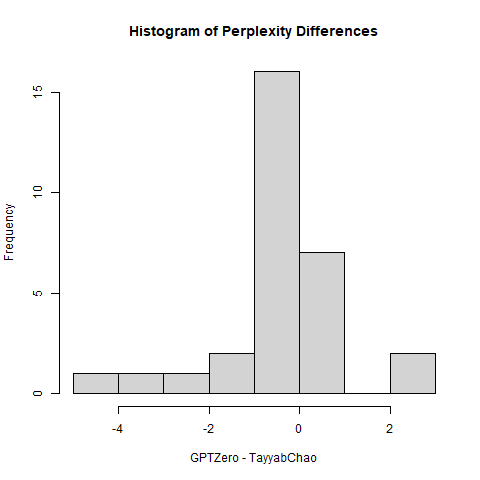

In [66]:
%%R
df$difference <- df$gptzero - df$tayyabchao
hist(df$difference,
     main = "Histogram of Perplexity Differences",
     xlab = "GPTZero - TayyabChao")

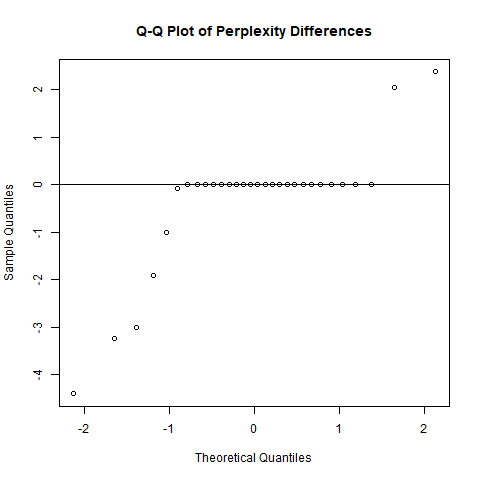

In [64]:
%%R
qqnorm(df$difference, main = "Q-Q Plot of Perplexity Differences")
qqline(df$difference)

In [68]:
%%R
t.test(x = df$gptzero, y = df$tayyabchao,
       alternative = "two.sided", mu = 0, paired = TRUE, conf.level = 0.99)


	Paired t-test

data:  df$gptzero and df$tayyabchao
t = -1.2757, df = 29, p-value = 0.2122
alternative hypothesis: true difference in means is not equal to 0
99 percent confidence interval:
 -0.9710903  0.3566243
sample estimates:
mean of the differences 
              -0.307233 



Based on the resuling p-value of 0.2122, there is not enough evidence to reject the null hypothesis that $\mu_d = 0$. Furthermore, we can expect 99% of all differences to be between -0.97 and 0.36, so the difference between GPTZero and TayyabChao's perplexities should be negligible.